In [1]:
import os

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


In [2]:
DATA_DIR = "../data/SKU110K_fixed"
IMG_DIR = os.path.join(DATA_DIR, "images")
ANN_DIR = os.path.join(DATA_DIR, "annotations")

train_csv_path = os.path.join(ANN_DIR, "annotations_train.csv")
print("CSV yolu:", train_csv_path)

train_df = pd.read_csv(train_csv_path, header=None)
print("Toplam satır:", len(train_df))
train_df.head()


CSV yolu: ../data/SKU110K_fixed\annotations\annotations_train.csv
Toplam satır: 1208482


,0,1,2,3,4,5,6,7
0,train_0.jpg,208,537,422,814,object,3024,3024
1,train_0.jpg,1268,1923,1365,2209,object,3024,3024
2,train_0.jpg,1135,2074,1261,2166,object,3024,3024
3,train_0.jpg,1045,2085,1122,2258,object,3024,3024
4,train_0.jpg,976,2036,1040,2177,object,3024,3024


In [3]:
samples_small = train_df.sample(1000, random_state=42).reset_index(drop=True)
print(samples_small.head())


                0     1     2     3     4       5     6     7
0  train_6454.jpg  1749  2818  2028  2951  object  2336  4160
1  train_1504.jpg  2302  1857  2450  1902  object  2448  3264
2  train_6041.jpg  1894  2242  2081  2364  object  3120  4160
3  train_5300.jpg  1261   965  1564  1184  object  4160  3120
4  train_8115.jpg  1058  2402  1197  2605  object  2448  3264


In [4]:
class SKUDataset(Dataset):
    def __init__(self, df, img_dir):
        self.df = df
        self.img_dir = img_dir

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_name = row[0]
        x1, y1, x2, y2 = row[1], row[2], row[3], row[4]

        img_path = os.path.join(self.img_dir, img_name)
        img = Image.open(img_path).convert("RGB")
        img = img.resize((224, 224))

        img_np = np.array(img, dtype=np.float32) / 255.0
        img_tensor = torch.from_numpy(img_np).permute(2, 0, 1)

        target = torch.tensor([x1, y1, x2, y2], dtype=torch.float32)

        return img_tensor, target


In [5]:
dataset = SKUDataset(samples_small, IMG_DIR)
train_loader = DataLoader(dataset, batch_size=8, shuffle=True)

len(dataset)


1000

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Kullanılan cihaz:", device)


Kullanılan cihaz: cpu


[EfficientDetD0-Lite] Epoch 1/3 - Loss: 821037.8701
[EfficientDetD0-Lite] Epoch 2/3 - Loss: 564423.6279
[EfficientDetD0-Lite] Epoch 3/3 - Loss: 541258.9076
EfficientDetD0-Lite için Ortalama IoU: 0.0018944634357467294


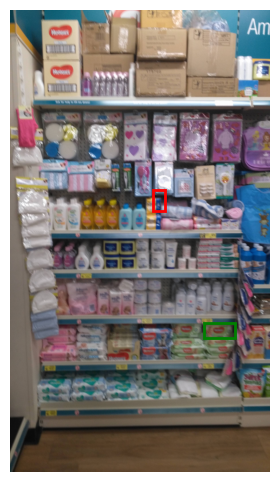

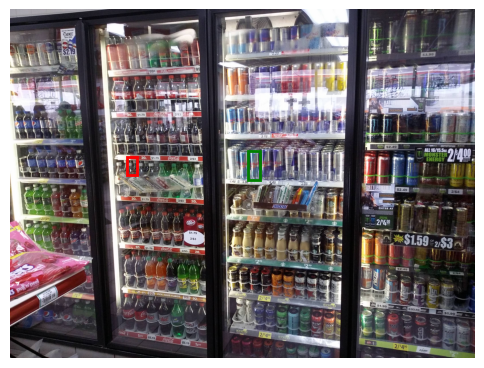

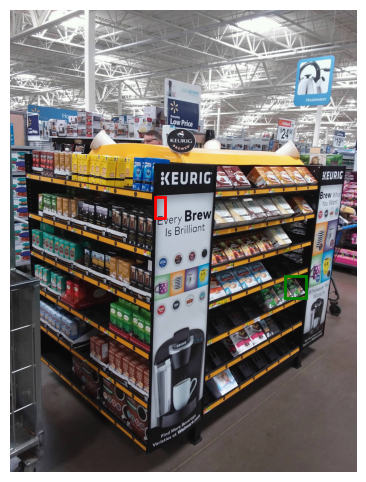

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SeparableConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.depthwise = nn.Conv2d(in_ch, in_ch, kernel_size=3, padding=1, groups=in_ch, bias=False)
        self.pointwise = nn.Conv2d(in_ch, out_ch, kernel_size=1, bias=False)
        self.bn = nn.BatchNorm2d(out_ch)
        self.act = nn.ReLU()

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        x = self.bn(x)
        x = self.act(x)
        return x


class EfficientDetD0Lite(nn.Module):
    def __init__(self):
        super().__init__()

        self.stem = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU()
        )

        self.block1 = SeparableConvBlock(16, 32)
        self.pool1  = nn.MaxPool2d(2)

        self.block2 = SeparableConvBlock(32, 64)
        self.pool2  = nn.MaxPool2d(2)

        self.block3 = SeparableConvBlock(64, 128)
        self.pool3  = nn.MaxPool2d(2)

        self.fuse_conv = nn.Conv2d(128, 128, kernel_size=1)
        self.fuse_bn   = nn.BatchNorm2d(128)
        self.fuse_act  = nn.ReLU()

        self.regressor = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 14 * 14, 256),
            nn.ReLU(),
            nn.Linear(256, 4)
        )

    def forward(self, x):
        x = self.stem(x)
        x = self.block1(x)
        x = self.pool1(x)

        x = self.block2(x)
        x = self.pool2(x)

        x = self.block3(x)
        x = self.pool3(x)

        x = self.fuse_conv(x)
        x = self.fuse_bn(x)
        x = self.fuse_act(x)

        out = self.regressor(x)
        return out


model_eff = EfficientDetD0Lite().to(device)

criterion_eff = nn.MSELoss()
optimizer_eff = torch.optim.Adam(model_eff.parameters(), lr=1e-3)

EPOCHS_EFF = 3
loss_history_eff = []

for epoch in range(EPOCHS_EFF):
    model_eff.train()
    running_loss = 0.0

    for imgs, targets in train_loader:
        imgs = imgs.to(device)
        targets = targets.to(device)

        optimizer_eff.zero_grad()
        outputs = model_eff(imgs)
        loss = criterion_eff(outputs, targets)
        loss.backward()
        optimizer_eff.step()

        running_loss += loss.item() * imgs.size(0)
        loss_history_eff.append(loss.item())

    epoch_loss = running_loss / len(dataset)
    print(f"[EfficientDetD0-Lite] Epoch {epoch+1}/{EPOCHS_EFF} - Loss: {epoch_loss:.4f}")


# IoU Hesabi
import numpy as np

def iou(box1, box2):
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    inter_w = max(0.0, x2 - x1)
    inter_h = max(0.0, y2 - y1)
    inter = inter_w * inter_h

    area1 = max(0.0, box1[2] - box1[0]) * max(0.0, box1[3] - box1[1])
    area2 = max(0.0, box2[2] - box2[0]) * max(0.0, box2[3] - box2[1])

    union = area1 + area2 - inter + 1e-6
    return inter / union

model_eff.eval()
ious_eff = []

with torch.no_grad():
    for i, (imgs, targets) in enumerate(train_loader):
        imgs = imgs.to(device)
        preds = model_eff(imgs).cpu().numpy()
        gts = targets.cpu().numpy()

        for gt, pr in zip(gts, preds):
            ious_eff.append(iou(gt, pr))

        if i >= 9:
            break

print("EfficientDetD0-Lite için Ortalama IoU:", float(np.mean(ious_eff)))


# Tahmin görselleştirme
import matplotlib.patches as patches

def show_prediction_eff(idx):
    row = samples_small.iloc[idx]
    img_name = row[0]
    x1, y1, x2, y2 = row[1], row[2], row[3], row[4]

    img_path = os.path.join(IMG_DIR, img_name)
    img = Image.open(img_path).convert("RGB")

    img_resized = img.resize((224, 224))
    img_np = np.array(img_resized, dtype=np.float32) / 255.0
    img_tensor = torch.from_numpy(img_np).permute(2, 0, 1).unsqueeze(0).to(device)

    model_eff.eval()
    with torch.no_grad():
        pred = model_eff(img_tensor)[0].cpu().numpy()

    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    ax.imshow(img)

    ax.add_patch(patches.Rectangle((x1, y1), (x2-x1), (y2-y1),
                                   linewidth=2, edgecolor='g', facecolor='none'))
    ax.add_patch(patches.Rectangle((pred[0], pred[1]), (pred[2]-pred[0]), (pred[3]-pred[1]),
                                   linewidth=2, edgecolor='r', facecolor='none'))

    plt.axis("off")
    plt.show()


show_prediction_eff(0)
show_prediction_eff(10)
show_prediction_eff(20)
